In [1]:
%pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd

def compute_Ichimoku_on_DataFrame(df: pd.DataFrame):
    # Compute rolling max/min for the necessary periods
    highest_9 = df['high'].rolling(window=9).max()
    lowest_9 = df['low'].rolling(window=9).min()

    highest_26 = df['high'].rolling(window=26).max()
    lowest_26 = df['low'].rolling(window=26).min()

    highest_52 = df['high'].rolling(window=52).max()
    lowest_52 = df['low'].rolling(window=52).min()

    # Compute Ichimoku components
    df['tenkan'] = (highest_9 + lowest_9) / 2
    df['kijun'] = (highest_26 + lowest_26) / 2
    df['ssa'] = (df['tenkan'] + df['kijun']) / 2
    df['ssb'] = (highest_52 + lowest_52) / 2

    # Shift the "ssa" and "ssb" values to align them properly
    df['ssa'] = df['ssa'].shift(26)
    df['ssb'] = df['ssb'].shift(26)
    
    return df

path = "C:/Users/tessa/MotiveWave Data/"

### M5 ###
df_M5 = pd.read_csv(
    filepath_or_buffer=path+"@MES.CME.TOP_STEP_5.csv",
    names=["datetime", "open", "high", "low","close", "volume"],
    header=None,
    delimiter=","
)
df_M5['datetime'] = pd.to_datetime(df_M5['datetime'], format='%d/%m/%Y %H:%M:%S')
df_M5 = compute_Ichimoku_on_DataFrame(df_M5)

### M15 ###
df_M15 = pd.read_csv(
    filepath_or_buffer=path+"@MES.CME.TOP_STEP_15.csv",
    names=["datetime", "open", "high", "low","close", "volume"],
    header=None,
    delimiter=","
)
df_M15['datetime'] = pd.to_datetime(df_M15['datetime'], format='%d/%m/%Y %H:%M:%S')
df_M15 = compute_Ichimoku_on_DataFrame(df_M15)

### H1 ###
df_H1 = pd.read_csv(
    filepath_or_buffer=path+"@MES.CME.TOP_STEP_60.csv",
    names=["datetime", "open", "high", "low","close", "volume"],
    header=None,
    delimiter=","
)
df_H1['datetime'] = pd.to_datetime(df_H1['datetime'], format='%d/%m/%Y %H:%M:%S')
df_H1 = compute_Ichimoku_on_DataFrame(df_H1)


### ADD SSA AND SSB DATA FROM M15 AND H1 ###
df_M5 = pd.merge(df_M5, df_M15[['datetime', 'ssa', 'ssb']], on='datetime', how='left', suffixes = ["", "_m15"])
df_M5["ssa_m15"] = df_M5["ssa_m15"].ffill()
df_M5["ssb_m15"] = df_M5["ssb_m15"].ffill()

df_M5 = pd.merge(df_M5, df_H1[['datetime', 'ssa', 'ssb']], on='datetime', how='left', suffixes = ["", "_h1"])
df_M5["ssa_h1"] = df_M5["ssa_h1"].ffill()
df_M5["ssb_h1"] = df_M5["ssb_h1"].ffill()

del df_M15
del df_H1

# 1. Convertir la colonne datetime en index pour faciliter la resampling des données journalières
df_M5.set_index('datetime', inplace=True)

# 2. Calculer les prix journaliers : High, Low et Close (resampling daily)
df_daily = df_M5.resample('D').agg({'high': 'max', 'low': 'min', 'close': 'last'})

# 3. Calculer les niveaux de point pivot (PP, R3, R2, R1, S1, S2, S3)
df_daily['PP'] = (df_daily['high'] + df_daily['low'] + df_daily['close']) / 3
df_daily['R1'] = (2 * df_daily['PP']) - df_daily['low']
df_daily['R2'] = df_daily['PP'] + (df_daily['high'] - df_daily['low'])
df_daily['R3'] = df_daily['high'] + 2 * (df_daily['PP'] - df_daily['low'])
df_daily['S1'] = (2 * df_daily['PP']) - df_daily['high']
df_daily['S2'] = df_daily['PP'] - (df_daily['high'] - df_daily['low'])
df_daily['S3'] = df_daily['low'] - 2 * (df_daily['high'] - df_daily['PP'])

# 4. Fusionner ces points pivots journaliers dans le dataframe 5min
# On va faire un merge sur l'index (qui est 'datetime' après resampling)
df_M5 = df_M5.merge(df_daily[['PP', 'R1', 'R2', 'R3', 'S1', 'S2', 'S3']], 
                     left_index=True, right_index=True, how='left')

# 5. Optionnel : remplir les valeurs manquantes si nécessaire (avec ffill ou bfill)
df_M5[['PP', 'R1', 'R2', 'R3', 'S1', 'S2', 'S3']] = df_M5[['PP', 'R1', 'R2', 'R3', 'S1', 'S2', 'S3']].ffill()

# Affichage du DataFrame mis à jour
df_M5.dropna(inplace=True)
df_M5.reset_index(inplace=True)

del df_daily

df_M5


,datetime,open,high,low,close,volume,tenkan,kijun,ssa,ssb,...,ssb_m15,ssa_h1,ssb_h1,PP,R1,R2,R3,S1,S2,S3
0,2019-08-08 08:00:00,2894.00,2894.25,2890.75,2891.25,460,2892.875,2892.375,2888.7500,2882.375,...,2857.125,2854.2500,2854.750,2916.916667,2963.333333,2987.916667,3034.333333,2892.333333,2845.916667,2821.333333
1,2019-08-08 08:05:00,2891.25,2893.25,2890.50,2892.50,242,2892.750,2892.375,2888.7500,2882.375,...,2857.125,2854.2500,2854.750,2916.916667,2963.333333,2987.916667,3034.333333,2892.333333,2845.916667,2821.333333
2,2019-08-08 08:10:00,2892.50,2894.25,2891.75,2893.75,248,2892.750,2892.375,2889.0000,2882.375,...,2857.125,2854.2500,2854.750,2916.916667,2963.333333,2987.916667,3034.333333,2892.333333,2845.916667,2821.333333
3,2019-08-08 08:15:00,2894.00,2894.00,2893.25,2893.25,251,2892.625,2892.375,2889.1875,2882.375,...,2857.125,2854.2500,2854.750,2916.916667,2963.333333,2987.916667,3034.333333,2892.333333,2845.916667,2821.333333
4,2019-08-08 08:20:00,2893.50,2896.50,2893.50,2896.25,489,2893.500,2893.125,2889.6875,2882.375,...,2857.125,2854.2500,2854.750,2916.916667,2963.333333,2987.916667,3034.333333,2892.333333,2845.916667,2821.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361678,2025-02-14 13:00:00,6124.75,6127.00,6124.50,6125.75,2076,6124.125,6128.250,6137.6250,6139.625,...,6116.500,6066.1875,6059.625,6131.666667,6142.083333,6157.416667,6167.833333,6116.333333,6105.916667,6090.583333
361679,2025-02-14 13:05:00,6125.50,6125.75,6124.25,6125.25,693,6124.125,6128.000,6137.5000,6139.625,...,6116.500,6066.1875,6059.625,6131.666667,6142.083333,6157.416667,6167.833333,6116.333333,6105.916667,6090.583333
361680,2025-02-14 13:10:00,6125.25,6127.25,6125.00,6126.75,1305,6124.250,6127.500,6137.4375,6139.625,...,6116.500,6066.1875,6059.625,6131.666667,6142.083333,6157.416667,6167.833333,6116.333333,6105.916667,6090.583333
361681,2025-02-14 13:15:00,6126.75,6128.00,6126.25,6127.00,1292,6124.625,6127.375,6137.1875,6139.625,...,6116.500,6066.1875,6059.625,6131.666667,6142.083333,6157.416667,6167.833333,6116.333333,6105.916667,6090.583333


In [ ]:
import strategy_runner
from strategies.DTP_Strategy import DTP
pd.options.mode.chained_assignment = None  # default='warn'

trades_database = {}

params = {
    # "times_below_before_breakeven": [2,3],
    "slInTicks": [25,50,75,100],
    "tpInTicks": [25,50,75,100, 120],
    "onlyUSSession": [True, False]
}
use3UT = False
times_below_before_breakeven = 0 # if == 0 => pas de breakeven durant les trades
useAllEntryPoints = False

strategy = DTP(df_M5[0:350_000], use3UT, useAllEntryPoints)
iteration = 1
for sl in params["slInTicks"]:
    # for b in params["times_below_before_breakeven"]:
        for tp in params["tpInTicks"]:
            for onlyUSSession in params["onlyUSSession"]:
                if sl <= tp and tp/sl < 1.6: # On ne veut que des trade avec un risk ratio >= à 1
                    title = f'sl: {sl}, tp: {tp}, US_hours_only: {onlyUSSession}'
                    print(f'iteration n°{iteration}, parameters: {title}')
                    trades = strategy_runner.strategyLoop(strategy, sl, tp, onlyUSSession, times_below_before_breakeven)
                    trades_database[iteration] = [trades, sl, tp, onlyUSSession]
                    iteration+=1


iteration n°1, parameters: sl: 25, tp: 25, US_hours_only: True


100%|██████████| 349999/349999 [01:40<00:00, 3465.94it/s]


iteration n°2, parameters: sl: 25, tp: 25, US_hours_only: False


 50%|████▉     | 173809/349999 [01:32<01:32, 1901.83it/s]

In [6]:
### SAVE THE DATA ###
import pickle 
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

### LOAD THE DATA ###
def load_object(filename):
    with open(filename, 'rb') as input: 
        return pickle.load(input)

In [7]:
save_object(trades_database, 'trade_datas/basicEntries_1UT_levels_breakeven=3.pkl')

In [7]:
trades_database2 = load_object('trade_datas/basicEntries_3UT_levels_breakeven=2.pkl')
# BEST WINRATE SO FAR : trades_database_basic_no_3UT_levels.pkl with 0.5813

In [ ]:
winrate_dictionnary = {}

for id, trade_data in trades_database.items():
    df, sl, tp, onlyUSSession = trade_data
    wins = df.loc[df['profit']>0, 'position'].count()
    loss = df.loc[df['profit']<0, 'position'].count()
    breakevens = df.loc[df['profit']==0, 'position'].count()
    avg_gain_from_start = df.loc[df['profit']>=0, 'profit_from_start(%)'].mean()
    avg_loss_from_start = df.loc[df['profit']<0, 'profit_from_start(%)'].mean()
    median_times_below_breakeven = df['times_below_breakeven'].median()
    total_pnl_from_start = df['profit_from_start(%)'].sum()
    winrate = 0.0 if loss+wins == 0.0 else 100*wins/(loss+wins)
    quantiles_duration = (df["exit_date"]-df["entry_date"]).quantile([0.50,0.75])

    winrate_dictionnary[id] = {
        'winrate (%)': round(winrate, 3), 
        "total_pnl_from_start (%)": round(total_pnl_from_start, 2),
        "avg_gain_from_start (%)": round(avg_gain_from_start, 2),
        "avg_loss_from_start (%)": round(avg_loss_from_start,2),
        "median duration": quantiles_duration.loc[0.50], 
        "75percent duration": quantiles_duration.loc[0.75],
        'risk_ratio': round(tp/sl, 2), 
        'TP/SL (Ticks)': (tp, sl),
        'nbr wins/loss/breakeven' : (wins, loss, breakevens),
        "median_times_below_breakeven": round(median_times_below_breakeven,2),
        'US_session_only' : onlyUSSession,
        #'nbr_of_trades': wins.item()+loss.item(), 
    }

def sort_by_winrate(item):
    _, dict_values = item
    return dict_values['total_pnl_from_start (%)']

winrate_dictionnary = dict(sorted(winrate_dictionnary.items(), key=sort_by_winrate))

In [4]:
trades_sample, _, _, _ = trades_database[1]
print(f"start date : {trades_sample.iloc[0]["entry_date"]}, end date : {trades_sample.iloc[-1]["entry_date"]}")

start date : 2019-08-08 20:35:00, end date : 2020-06-26 20:10:00


In [4]:
pd.DataFrame.from_dict(winrate_dictionnary, orient='index')

,winrate (%),total_pnl_from_start (%),avg_gain_from_start (%),avg_loss_from_start (%),median duration,75percent duration,risk_ratio,TP/SL (Ticks),nbr wins/loss/breakeven,median_times_below_breakeven,US_session_only
8,35.9894,-138.729375,0.231376,-0.519196,0 days 01:55:00,0 days 03:25:00,1.0000,"(75, 75)","(271, 482, 211)",1.0,False
12,36.9732,-133.336875,0.266773,-0.687458,0 days 02:20:00,0 days 04:05:00,1.0000,"(100, 100)","(193, 329, 155)",1.0,False
4,37.8234,-110.880000,0.209075,-0.355559,0 days 01:25:00,0 days 02:25:00,1.0000,"(50, 50)","(424, 697, 231)",1.0,False
14,34.9246,-109.700625,0.271336,-0.696986,0 days 02:25:00,0 days 04:20:00,1.2000,"(120, 100)","(139, 259, 122)",1.0,False
10,32.9068,-109.443750,0.264627,-0.533997,0 days 01:55:00,0 days 03:30:00,1.3333,"(100, 75)","(180, 367, 147)",1.0,False
6,31.6808,-93.369375,0.243729,-0.357219,0 days 01:30:00,0 days 02:45:00,1.5000,"(75, 50)","(262, 565, 183)",1.0,False
2,41.5890,-57.481875,0.151836,-0.185391,0 days 00:35:00,0 days 01:15:00,1.0000,"(25, 25)","(759, 1066, 164)",0.0,False
7,48.4594,-26.328750,0.244841,-0.451804,0 days 01:35:00,0 days 02:35:00,1.0000,"(75, 75)","(173, 184, 59)",1.0,True
11,51.1719,-25.421250,0.259454,-0.579060,0 days 01:50:00,0 days 03:00:00,1.0000,"(100, 100)","(131, 125, 50)",1.0,True
3,46.0803,-23.915625,0.216242,-0.327121,0 days 01:20:00,0 days 02:08:45,1.0000,"(50, 50)","(241, 282, 75)",1.0,True


In [12]:
pd.DataFrame.from_dict(winrate_dictionnary, orient='index')

,winrate (%),total_pnl_from_start (%),avg_gain_from_start (%),avg_loss_from_start (%),median duration,75percent duration,risk_ratio,TP/SL (Ticks),nbr wins/loss/breakeven,median_times_below_breakeven,US_session_only
8,36.5817,-110.938125,0.187973,-0.523116,0 days 01:35:00,0 days 02:55:00,1.0000,"(75, 75)","(244, 423, 343)",1.0,False
12,37.2247,-108.001875,0.211403,-0.697171,0 days 01:50:00,0 days 03:35:00,1.0000,"(100, 100)","(169, 285, 260)",1.0,False
10,32.5103,-90.821250,0.211559,-0.536827,0 days 01:35:00,0 days 03:05:00,1.3333,"(100, 75)","(158, 328, 245)",1.0,False
14,34.7953,-90.727500,0.207566,-0.706564,0 days 01:55:00,0 days 03:40:00,1.2000,"(120, 100)","(119, 223, 203)",1.0,False
4,39.3970,-85.890000,0.166134,-0.362848,0 days 01:10:00,0 days 02:07:30,1.0000,"(50, 50)","(392, 603, 408)",1.0,False
6,32.6503,-68.075625,0.197054,-0.360319,0 days 01:15:00,0 days 02:20:00,1.5000,"(75, 50)","(239, 493, 317)",1.0,False
2,42.8068,-46.233750,0.127754,-0.186634,0 days 00:35:00,0 days 01:05:00,1.0000,"(25, 25)","(729, 974, 332)",0.0,False
7,47.6190,-18.750000,0.221328,-0.467761,0 days 01:25:00,0 days 02:25:00,1.0000,"(75, 75)","(150, 165, 114)",1.0,True
1,43.7077,-17.733750,0.136603,-0.185472,0 days 00:30:00,0 days 00:55:00,1.0000,"(25, 25)","(323, 416, 112)",0.0,True
3,47.2648,-15.783750,0.181304,-0.344595,0 days 01:05:00,0 days 01:55:00,1.0000,"(50, 50)","(216, 241, 155)",1.0,True


In [9]:
pd.DataFrame.from_dict(winrate_dictionnary, orient='index')

,winrate (%),avg_gain_from_start (%),avg_loss_from_start (%),total_pnl_from_start (%),median duration,75percent duration,risk_ratio,SL (Ticks),TP (Ticks),nbr wins/loss/breakeven,times_below_breakeven,US_session_only
13,100.0,0.034760,NaN,8.064375,0 days 00:05:00,0 days 00:25:00,1.2000,100,120,"(30, 0, 202)",0.81,True
9,100.0,0.035339,NaN,10.672500,0 days 00:05:00,0 days 00:25:00,1.3333,75,100,"(34, 0, 268)",0.82,True
11,100.0,0.035339,NaN,10.672500,0 days 00:05:00,0 days 00:25:00,1.0000,100,100,"(34, 0, 268)",0.82,True
14,100.0,0.037096,NaN,17.064375,0 days 00:05:00,0 days 00:20:00,1.2000,100,120,"(40, 0, 420)",0.85,False
5,100.0,0.046769,NaN,17.304375,0 days 00:05:00,0 days 00:20:00,1.5000,50,75,"(46, 0, 324)",0.81,True
7,100.0,0.046769,NaN,17.304375,0 days 00:05:00,0 days 00:20:00,1.0000,75,75,"(46, 0, 324)",0.81,True
3,100.0,0.041365,NaN,19.565625,0 days 00:05:00,0 days 00:20:00,1.0000,50,50,"(62, 0, 411)",0.80,True
1,100.0,0.036638,NaN,20.480625,0 days 00:05:00,0 days 00:15:00,1.0000,25,25,"(110, 0, 449)",0.74,True
10,100.0,0.038624,NaN,22.672500,0 days 00:05:00,0 days 00:20:00,1.3333,75,100,"(50, 0, 537)",0.84,False
12,100.0,0.038624,NaN,22.672500,0 days 00:05:00,0 days 00:20:00,1.0000,100,100,"(50, 0, 537)",0.84,False


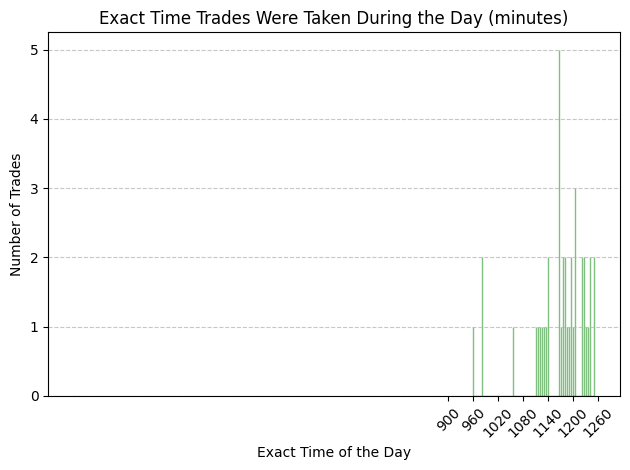

In [9]:
import matplotlib.pyplot as plt

id = 7
df, _, _, _ = trades_database[id]

df_hist_w = df[df['profit']>0]['entry_date'].apply(lambda x: x.hour*60 + x.minute)
df_hist_l = df[df['profit']<0]['entry_date'].apply(lambda x: x.hour*60 + x.minute)

# Plot the histogram
plt.hist(df_hist_w, bins=1440, edgecolor='green', alpha=0.5)
plt.hist(df_hist_l, bins=1440, edgecolor='red', alpha=0.5)

plt.xlabel('Exact Time of the Day')
plt.ylabel('Number of Trades')
plt.title('Exact Time Trades Were Taken During the Day (minutes)')
plt.xticks(range(900, 1320, 60), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Ensures labels fit inside the plot
plt.show()

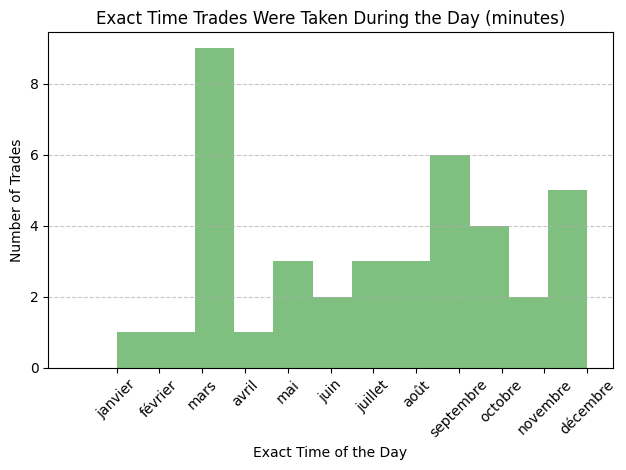

In [11]:
import matplotlib.pyplot as plt

id = 7
df, _, _, _ = trades_database[id]

df_hist_w = df[df['profit']>0]['entry_date'].dt.month
df_hist_l = df[df['profit']<0]['entry_date'].dt.month
months = ['janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août', 'septembre', 'octobre', 'novembre', 'décembre']
# Plot the histogram
plt.hist(df_hist_w, bins=12, color='green', alpha=0.5)
plt.hist(df_hist_l, bins=12, color='red', alpha=0.5)

plt.xlabel('Exact Time of the Day')
plt.ylabel('Number of Trades')
plt.title('Exact Time Trades Were Taken During the Day (minutes)')
plt.xticks(rotation=45, ticks=range(1, 13), labels=months)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Ensures labels fit inside the plot
plt.show()

choses à faire pour continuer à backtest :
- avoir le temps moyen d'un trade avec la stratégie DTP
- regarder si le type de position (short ou long) a un impact sur le winrate
- continuer à améliorer la stratégie avec:
    - les autres conditions d'entrées de la strat DTP (ex: taille de la bougie)
    - des conditions sur les niveaux pivot
    - des conditions pour savoir si on est en range
    - faire en sorte que le tp/sl s'adapte à la distance au pivot
- calculer le profit réel en $
- stop loss suiveur : passe en breakeven sous certaines conditions